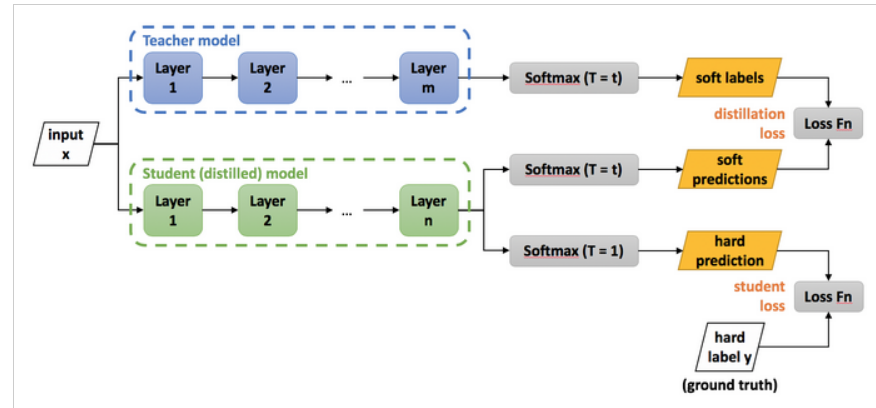



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
train = pd.read_csv('/content/drive/Shareddrives/2022건설기계오일상태분류AI경진대회/dataset/train.csv')
test = pd.read_csv('/content/drive/Shareddrives/2022건설기계오일상태분류AI경진대회/dataset/test.csv')

In [ ]:
train.isnull().sum()

ID                         0
COMPONENT_ARBITRARY        0
ANONYMOUS_1                0
YEAR                       0
SAMPLE_TRANSFER_DAY        0
ANONYMOUS_2                0
AG                         0
AL                         0
B                          0
BA                         0
BE                         0
CA                         0
CD                      1394
CO                         0
CR                         0
CU                         0
FH2O                   10205
FNOX                   10205
FOPTIMETHGLY           10205
FOXID                  10205
FSO4                   10205
FTBN                   10205
FE                         0
FUEL                   10205
H2O                        0
K                       2299
LI                         0
MG                         0
MN                         0
MO                         0
NA                         0
NI                         0
P                          0
PB                         0
PQINDEX       

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
CFG = {
    'EPOCHS': 50,
    'LEARNING_RATE':0.01, # min 0.0001
    'BATCH_SIZE':64,
    'SEED':2022
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [ ]:
categorical_features = ['COMPONENT_ARBITRARY','YEAR']
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

In [ ]:
train = pd.read_csv('/content/drive/Shareddrives/2022건설기계오일상태분류AI경진대회/dataset/train.csv')
test = pd.read_csv('/content/drive/Shareddrives/2022건설기계오일상태분류AI경진대회/dataset/test.csv')

In [ ]:
"""
for i in (2016,2017,2018,2019,2020):
  train.loc[train['YEAR'] ==i , 'YEAR'] = 0

for i in (2012,2013,2014,2015,2021):
  train.loc[train['YEAR'] ==i , 'YEAR'] = 1

for i in (2007,2008,2011,2022):
  train.loc[train['YEAR'] ==i , 'YEAR'] = 2

for i in (2009,2010):
  train.loc[train['YEAR'] ==i , 'YEAR'] = 3

  for i in (2016,2017,2018,2019,2020):
  test.loc[test['YEAR'] ==i , 'YEAR'] = 0

for i in (2012,2013,2014,2015,2021):
  test.loc[test['YEAR'] ==i , 'YEAR'] = 1

for i in (2007,2008,2011,2022):
  test.loc[test['YEAR'] ==i , 'YEAR'] = 2

for i in (2009,2010):
  test.loc[test['YEAR'] ==i , 'YEAR'] = 3
  """

"\nfor i in (2016,2017,2018,2019,2020):\n  train.loc[train['YEAR'] ==i , 'YEAR'] = 0\n\nfor i in (2012,2013,2014,2015,2021):\n  train.loc[train['YEAR'] ==i , 'YEAR'] = 1\n\nfor i in (2007,2008,2011,2022):\n  train.loc[train['YEAR'] ==i , 'YEAR'] = 2\n\nfor i in (2009,2010):\n  train.loc[train['YEAR'] ==i , 'YEAR'] = 3\n\n  for i in (2016,2017,2018,2019,2020):\n  test.loc[test['YEAR'] ==i , 'YEAR'] = 0\n\nfor i in (2012,2013,2014,2015,2021):\n  test.loc[test['YEAR'] ==i , 'YEAR'] = 1\n\nfor i in (2007,2008,2011,2022):\n  test.loc[test['YEAR'] ==i , 'YEAR'] = 2\n\nfor i in (2009,2010):\n  test.loc[test['YEAR'] ==i , 'YEAR'] = 3\n  "

In [ ]:
drop_list = ['FH2O',
 'FNOX',
 'FOPTIMETHGLY',
 'FOXID',
 'FSO4',
 'FTBN',
 'FUEL',
 'SOOTPERCENTAGE',
 'U100',
 'U75',
 'U50',
 'U25',
 'U20',
 'U14',
 'U6',
 'U4',
 'V100']

In [ ]:
train = train.drop(drop_list, axis=1)

In [ ]:
train = train.fillna(0)
test = test.fillna(0)

In [ ]:
col_list = train.columns

In [ ]:
col_list

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR',
       'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FE', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA',
       'NI', 'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40',
       'ZN', 'Y_LABEL'],
      dtype='object')

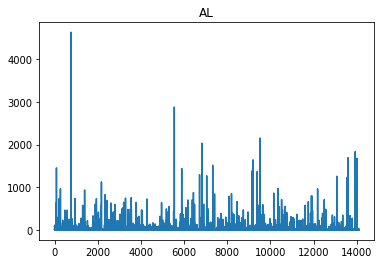

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train['AL'])
plt.title('AL')
plt.show()

In [ ]:
print(train[train['Y_LABEL']==1]['AL'].describe())
print()
print(train[train['Y_LABEL']==0]['AL'].describe())

count    1203.000000
mean      118.188695
std       276.348977
min         0.000000
25%         3.000000
50%        22.000000
75%       112.000000
max      4630.000000
Name: AL, dtype: float64

count    12892.000000
mean         2.864877
std          3.630611
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         57.000000
Name: AL, dtype: float64


In [ ]:
train[train['ANONYMOUS_1']>=max(train['ANONYMOUS_1'])] 

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN,Y_LABEL
5970,TRAIN_05970,COMPONENT3,294451,2010,5,200,0,9,133,0,...,513,14980,0,3,0,0,0,141.3,16,0


In [ ]:
train[train['ANONYMOUS_1']>=max(train['ANONYMOUS_1'])] 
train[train['ANONYMOUS_2']>=8000] # ANONYMOUS_2 8000이상 지우기
train[train['AG']>=max(train['AG'])]
train[train['AL']>=2500] # OR AL max 지우기  둘다 y==1
train[train['B']>=1000]
train[train['BA']>=100]
train[train['BE']>=2.1] # y==0 4개 ,1 2개
train[train['CA']>=6000]
train[train['CD']>=3.7] # 2개 뺄지 1개뺄지
train[train['CO']>=10]
train[train['CR']>=900] # 애매
train[train['CU']>=2000] # y==0 5개 ,1 2개
train[train['FE']>=20000]
train[train['H2O']>=10] # 애매
train[train['K']>=200] # 애매 200 or 300 y==0 9개 ,1 2개
train[train['LI']>=40] # y==0 10개 ,1 1개
# MG 안함
train[train['MN']>=200]
train[train['MO']>=380]
train[train['NA']>=200]
train[train['NI']>=75] # y==0 5개 ,1 2개
# P 안함
train[train['PB']>=170] # y==0 11개 ,1 1개
train[train['PQINDEX']>=25000] #y==0 1개 ,1 1개
train[train['S']>=50000] #y==0 2개 ,1 1개
train[train['SB']>=23] # 애매  y==0 22개 ,1 1개
train[train['SI']>=3300]  #  y==0 10개 ,1 2개
train[train['SN']>=50] #  y==0 3개 ,1 1개
train[train['TI']>=100] # 애매  y==0 9개 ,1 1개
train[train['V']>=7.5] # y==0 9개 ,1 1개
train[train['V40']>=900]
# ZN 안함


"\ntrain[train['ANONYMOUS_2']>=8000] # ANONYMOUS_2 8000이상 지우기\ntrain[train['AG']>=max(train['AG'])]\ntrain[train['AL']>=2500] # OR AL max 지우기  둘다 y==1\ntrain[train['B']>=1000]\ntrain[train['BA']>=100]\ntrain[train['BE']>=2.1] # y==0 4개 ,1 2개\ntrain[train['CA']>=6000]\ntrain[train['CD']>=3.7] # 2개 뺄지 1개뺄지\ntrain[train['CO']>=10]\ntrain[train['CR']>=900] # 애매\ntrain[train['CU']>=2000] # y==0 5개 ,1 2개\ntrain[train['FE']>=20000]\ntrain[train['H2O']>=10] # 애매\ntrain[train['K']>=200] # 애매 200 or 300 y==0 9개 ,1 2개\ntrain[train['LI']>=40] # y==0 10개 ,1 1개\n# MG 안함\ntrain[train['MN']>=200]\ntrain[train['MO']>=380]\ntrain[train['NA']>=200]\ntrain[train['NI']>=75] # y==0 5개 ,1 2개\n# P 안함\ntrain[train['PB']>=170] # y==0 11개 ,1 1개\ntrain[train['PQINDEX']>=25000] #y==0 1개 ,1 1개\ntrain[train['S']>=50000] #y==0 2개 ,1 1개\ntrain[train['SB']>=23] # 애매  y==0 22개 ,1 1개\ntrain[train['SI']>=3300]  #  y==0 10개 ,1 2개\ntrain[train['SN']>=50] #  y==0 3개 ,1 1개\ntrain[train['TI']>=100] # 애매  y==0 9개 ,1 1개\ntrain[t

In [ ]:
a = pd.concat(
    [train[train['ANONYMOUS_1']>=40000],
     train[train['ANONYMOUS_2']>=8000],
    train[train['AG']>=max(train['AG'])],
# AL 안함
train[train['B']>=1000],
train[train['BA']>=100],
train[train['BE']>=2.1], # y==0 4개 ,1 2개
train[train['CA']>=6000],
train[train['CD']>=3.7], # 2개 뺄지 1개뺄지
train[train['CO']>=10],
train[train['CR']>=500], # 애매
train[train['CU']>=2000], # y==0 5개 ,1 2개
train[train['FE']>=20000],
train[train['H2O']>=10], # 애매
train[train['K']>=200], # 애매 200 or 300 y==0 9개 ,1 2개
train[train['LI']>=40], # y==0 10개 ,1 1개
# MG 안함
train[train['MN']>=200],
train[train['MO']>=380],
train[train['NA']>=200],
train[train['NI']>=75], # y==0 5개 ,1 2개
# P 안함
train[train['PB']>=170], # y==0 11개 ,1 1개
train[train['PQINDEX']>=25000], #y==0 1개 ,1 1개
train[train['S']>=50000], #y==0 2개 ,1 1개
train[train['SB']>=23], # 애매  y==0 22개 ,1 1개
train[train['SI']>=3300],  #  y==0 10개 ,1 2개
train[train['SN']>=50], #  y==0 3개 ,1 1개
train[train['TI']>=100], # 애매  y==0 9개 ,1 1개
train[train['V']>=7.5], # y==0 9개 ,1 1개
train[train['V40']>=900]])# ANONYMOUS_2 8000이상 지우기
train_index = a.index

In [ ]:
train_index = a[a['Y_LABEL']==0].index

In [ ]:
train = train.drop(index=train_index)

In [ ]:
all_X = train.drop(['ID', 'Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']

test = test.drop(['ID'], axis = 1)

In [ ]:
# AL 변수 가중치 부여
all_X[all_X['AL']>57] = all_X[all_X['AL']>57]*2  # 100너무 큼

In [ ]:
all_X[all_X['AL']>57]['AL']

2         220
60       1256
67        154
88       2906
175       598
         ... 
13785     550
13920     186
13925    3674
13990     350
14002    3354
Name: AL, Length: 478, dtype: int64

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [ ]:
from sklearn.preprocessing import RobustScaler
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:
        scaler = RobustScaler() #StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
le = LabelEncoder()
for col in categorical_features:    
    train_X[col] = le.fit_transform(train_X[col])
    val_X[col] = le.transform(val_X[col])
    if col in test.columns:
        test[col] = le.transform(test[col])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index])
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y

In [ ]:
train_dataset = CustomDataset(train_X, train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [ ]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=35, out_features=64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),

            nn.Linear(in_features=64, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
  
            nn.Linear(in_features=128, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            
            nn.Linear(in_features=512, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            
            nn.Linear(in_features=1024, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
           
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    best_score = 0
    best_model = None
    criterion = nn.BCELoss().to(device)
    
    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
  
        model.train()
        for X, y in tqdm(train_loader):
           
            X = X.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y.reshape(-1, 1))
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)
       
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')
        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
        
    return best_model 

In [ ]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device):
    model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(X.to(device))
            
            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())      
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1   

In [ ]:
#Val F1 Score : [0.80146]
model = Teacher()
model.eval()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-6, verbose=True)

teacher_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.21242] Val Loss : [0.17878] Val F1 Score : [0.83994]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.18966] Val Loss : [0.20296] Val F1 Score : [0.80911]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.18426] Val Loss : [0.17932] Val F1 Score : [0.83970]
Epoch 00003: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.17455] Val Loss : [0.18927] Val F1 Score : [0.80710]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.17044] Val Loss : [0.19245] Val F1 Score : [0.80911]
Epoch 00005: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.16977] Val Loss : [0.17480] Val F1 Score : [0.83963]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.16740] Val Loss : [0.17611] Val F1 Score : [0.83513]
Epoch 00007: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.16325] Val Loss : [0.18163] Val F1 Score : [0.81704]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.16309] Val Loss : [0.17212] Val F1 Score : [0.84480]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.16253] Val Loss : [0.17856] Val F1 Score : [0.83326]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.16432] Val Loss : [0.17466] Val F1 Score : [0.83139]
Epoch 00011: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.16329] Val Loss : [0.17378] Val F1 Score : [0.83939]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.16135] Val Loss : [0.17754] Val F1 Score : [0.82950]
Epoch 00013: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.16119] Val Loss : [0.17461] Val F1 Score : [0.83139]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.15844] Val Loss : [0.17455] Val F1 Score : [0.83139]
Epoch 00015: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.15771] Val Loss : [0.17511] Val F1 Score : [0.84067]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.16139] Val Loss : [0.17012] Val F1 Score : [0.84121]
Epoch 00017: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.15626] Val Loss : [0.17255] Val F1 Score : [0.83513]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.15647] Val Loss : [0.17403] Val F1 Score : [0.83326]
Epoch 00019: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.15814] Val Loss : [0.17635] Val F1 Score : [0.83139]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.15855] Val Loss : [0.18899] Val F1 Score : [0.81704]
Epoch 00021: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.15658] Val Loss : [0.17935] Val F1 Score : [0.82570]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.15667] Val Loss : [0.17397] Val F1 Score : [0.82950]
Epoch 00023: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.15750] Val Loss : [0.16931] Val F1 Score : [0.84404]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.15801] Val Loss : [0.18601] Val F1 Score : [0.81704]
Epoch 00025: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.15779] Val Loss : [0.17003] Val F1 Score : [0.84301]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.15865] Val Loss : [0.17194] Val F1 Score : [0.84480]
Epoch 00027: reducing learning rate of group 0 to 2.4414e-06.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.15657] Val Loss : [0.16854] Val F1 Score : [0.84480]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.15654] Val Loss : [0.16932] Val F1 Score : [0.84556]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.15621] Val Loss : [0.17212] Val F1 Score : [0.82950]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.15541] Val Loss : [0.17179] Val F1 Score : [0.84508]
Epoch 00031: reducing learning rate of group 0 to 1.2207e-06.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.15634] Val Loss : [0.17044] Val F1 Score : [0.84301]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.15655] Val Loss : [0.17335] Val F1 Score : [0.84508]
Epoch 00033: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.15684] Val Loss : [0.19144] Val F1 Score : [0.80911]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.15793] Val Loss : [0.17133] Val F1 Score : [0.84301]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.15727] Val Loss : [0.17398] Val F1 Score : [0.83223]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.15775] Val Loss : [0.17247] Val F1 Score : [0.82848]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.15624] Val Loss : [0.17263] Val F1 Score : [0.83963]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.15632] Val Loss : [0.17148] Val F1 Score : [0.84327]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.15655] Val Loss : [0.17569] Val F1 Score : [0.82095]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.15604] Val Loss : [0.19943] Val F1 Score : [0.80911]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.15666] Val Loss : [0.17307] Val F1 Score : [0.83513]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.15787] Val Loss : [0.17455] Val F1 Score : [0.82570]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.15767] Val Loss : [0.17497] Val F1 Score : [0.82570]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.15633] Val Loss : [0.16952] Val F1 Score : [0.84404]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.15847] Val Loss : [0.17507] Val F1 Score : [0.82570]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.15528] Val Loss : [0.17762] Val F1 Score : [0.81704]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [47], Train Loss : [0.15819] Val Loss : [0.17212] Val F1 Score : [0.83963]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [48], Train Loss : [0.15724] Val Loss : [0.17237] Val F1 Score : [0.83410]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [49], Train Loss : [0.15526] Val Loss : [0.17481] Val F1 Score : [0.84067]


In [ ]:
all_y.value_counts()

0    12892
1     1203
Name: Y_LABEL, dtype: int64

In [ ]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=18, out_features=64),
            #nn.BatchNorm1d(64),
            nn.ReLU(),
           
            nn.Linear(in_features=64, out_features=256),
            #nn.BatchNorm1d(256),
            nn.ReLU(),
           
            nn.Linear(in_features=256, out_features=64),
            #nn.BatchNorm1d(64),
            nn.ReLU(),
           
            nn.Linear(in_features=64, out_features=32),
            #nn.BatchNorm1d(32),
            nn.ReLU(),
          
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [ ]:
# nn.BCELoss, 가중치 부여  # 이거 성능 안좋음
numSample_list = [12765, 1187]
weights = [1 - (x / sum(numSample_list)) for x in numSample_list]
weights = torch.FloatTensor(weights).to(device)


In [ ]:
def distillation(student_logits, labels, teacher_logits, alpha):
    distillation_loss = nn.BCELoss()(student_logits, teacher_logits) #nn.BCELoss()weight=weights
    student_loss = nn.BCELoss()(student_logits, labels.reshape(-1, 1)) #nn.BCELoss()weight=weights
    #student_loss.weight=weights
    #distillation_loss.weight=weights
    return alpha * student_loss + (1-alpha) * distillation_loss

In [ ]:
def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.1)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

In [ ]:
new_train_loss = []
new_val_loss = []

In [ ]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    t_model.to(device)
    
    best_score = 0
    best_model = None

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
        s_model.train()
        t_model.eval()
        
        for X_t, X_s, y in tqdm(train_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()

            output = s_model(X_s)
            with torch.no_grad():
                teacher_output = t_model(X_t)
                
            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')
        new_train_loss.append(np.mean(train_loss))
        new_val_loss.append(np.mean(val_loss))

        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = s_model
            best_score = val_score
        
    return best_model

In [ ]:
def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X_t, X_s, y in tqdm(val_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = s_model(X_s)
            teacher_output = t_model(X_t)
            
            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None) # Distillation Loss는 KLDivLoss를 사용하여 Teacher Model의 예측값과 Student Model의 예측값을 비교하여 계산한다.
            val_loss.append(loss_b)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
        print(confusion_matrix(true_labels, pred_labels))
    return val_loss, val_f1    

In [ ]:
train_dataset = CustomDataset(train_X, train_y, True)
val_dataset = CustomDataset(val_X, val_y, True)

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)


In [ ]:
student_model = Student()
student_model.eval()
optimizer = torch.optim.Adam(student_model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-6, verbose=True)

best_student_model = student_train(student_model, teacher_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2552   26]
 [ 140  101]]
Epoch [0], Train Loss : [0.28817] Val Loss : [0.24375] Val F1 Score : [0.75871]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2560   18]
 [ 142   99]]
Epoch [1], Train Loss : [0.24560] Val Loss : [0.24271] Val F1 Score : [0.76138]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2573    5]
 [ 138  103]]
Epoch [2], Train Loss : [0.24045] Val Loss : [0.23195] Val F1 Score : [0.78161]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2565   13]
 [ 132  109]]
Epoch [3], Train Loss : [0.23351] Val Loss : [0.23185] Val F1 Score : [0.78653]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2563   15]
 [ 139  102]]
Epoch [4], Train Loss : [0.23535] Val Loss : [0.24171] Val F1 Score : [0.77033]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2558   20]
 [ 128  113]]
Epoch [5], Train Loss : [0.23751] Val Loss : [0.23650] Val F1 Score : [0.78808]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2572    6]
 [ 137  104]]
Epoch [6], Train Loss : [0.23937] Val Loss : [0.23250] Val F1 Score : [0.78277]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 140  101]]
Epoch [7], Train Loss : [0.23482] Val Loss : [0.23302] Val F1 Score : [0.78210]
Epoch 00008: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2574    4]
 [ 132  109]]
Epoch [8], Train Loss : [0.22992] Val Loss : [0.22776] Val F1 Score : [0.79504]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 136  105]]
Epoch [9], Train Loss : [0.22911] Val Loss : [0.22891] Val F1 Score : [0.79062]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2576    2]
 [ 132  109]]
Epoch [10], Train Loss : [0.22719] Val Loss : [0.22657] Val F1 Score : [0.79698]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2571    7]
 [ 129  112]]
Epoch [11], Train Loss : [0.22817] Val Loss : [0.22625] Val F1 Score : [0.79823]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 136  105]]
Epoch [12], Train Loss : [0.22835] Val Loss : [0.23070] Val F1 Score : [0.79062]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2576    2]
 [ 129  112]]
Epoch [13], Train Loss : [0.22737] Val Loss : [0.22910] Val F1 Score : [0.80309]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2577    1]
 [ 133  108]]
Epoch [14], Train Loss : [0.22844] Val Loss : [0.22913] Val F1 Score : [0.79590]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2568   10]
 [ 129  112]]
Epoch [15], Train Loss : [0.22607] Val Loss : [0.23555] Val F1 Score : [0.79536]
Epoch 00016: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 129  112]]
Epoch [16], Train Loss : [0.22751] Val Loss : [0.22403] Val F1 Score : [0.80508]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 132  109]]
Epoch [17], Train Loss : [0.22493] Val Loss : [0.22596] Val F1 Score : [0.79895]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 130  111]]
Epoch [18], Train Loss : [0.22505] Val Loss : [0.22537] Val F1 Score : [0.80304]
Epoch 00019: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2576    2]
 [ 130  111]]
Epoch [19], Train Loss : [0.22447] Val Loss : [0.22510] Val F1 Score : [0.80107]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2577    1]
 [ 130  111]]
Epoch [20], Train Loss : [0.22436] Val Loss : [0.22558] Val F1 Score : [0.80205]
Epoch 00021: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 130  111]]
Epoch [21], Train Loss : [0.22437] Val Loss : [0.22627] Val F1 Score : [0.80304]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [22], Train Loss : [0.22391] Val Loss : [0.22607] Val F1 Score : [0.80100]
Epoch 00023: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [23], Train Loss : [0.22371] Val Loss : [0.22606] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [24], Train Loss : [0.22354] Val Loss : [0.22612] Val F1 Score : [0.80100]
Epoch 00025: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 130  111]]
Epoch [25], Train Loss : [0.22386] Val Loss : [0.22581] Val F1 Score : [0.80304]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 130  111]]
Epoch [26], Train Loss : [0.22352] Val Loss : [0.22588] Val F1 Score : [0.80304]
Epoch 00027: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [27], Train Loss : [0.22389] Val Loss : [0.22607] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [28], Train Loss : [0.22357] Val Loss : [0.22605] Val F1 Score : [0.80100]
Epoch 00029: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [29], Train Loss : [0.22346] Val Loss : [0.22607] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [30], Train Loss : [0.22340] Val Loss : [0.22609] Val F1 Score : [0.80100]
Epoch 00031: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [31], Train Loss : [0.22365] Val Loss : [0.22608] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [32], Train Loss : [0.22401] Val Loss : [0.22609] Val F1 Score : [0.80100]
Epoch 00033: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [33], Train Loss : [0.22343] Val Loss : [0.22609] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [34], Train Loss : [0.22353] Val Loss : [0.22609] Val F1 Score : [0.80100]
Epoch 00035: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [35], Train Loss : [0.22355] Val Loss : [0.22609] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [36], Train Loss : [0.22398] Val Loss : [0.22609] Val F1 Score : [0.80100]
Epoch 00037: reducing learning rate of group 0 to 2.4414e-06.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [37], Train Loss : [0.22346] Val Loss : [0.22609] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [38], Train Loss : [0.22359] Val Loss : [0.22609] Val F1 Score : [0.80100]
Epoch 00039: reducing learning rate of group 0 to 1.2207e-06.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [39], Train Loss : [0.22346] Val Loss : [0.22609] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [40], Train Loss : [0.22369] Val Loss : [0.22609] Val F1 Score : [0.80100]
Epoch 00041: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [41], Train Loss : [0.22335] Val Loss : [0.22609] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [42], Train Loss : [0.22364] Val Loss : [0.22609] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [43], Train Loss : [0.22376] Val Loss : [0.22609] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [44], Train Loss : [0.22331] Val Loss : [0.22609] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [45], Train Loss : [0.22357] Val Loss : [0.22609] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [46], Train Loss : [0.22342] Val Loss : [0.22609] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [47], Train Loss : [0.22388] Val Loss : [0.22610] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [48], Train Loss : [0.22334] Val Loss : [0.22610] Val F1 Score : [0.80100]


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[[2578    0]
 [ 131  110]]
Epoch [49], Train Loss : [0.22357] Val Loss : [0.22610] Val F1 Score : [0.80100]


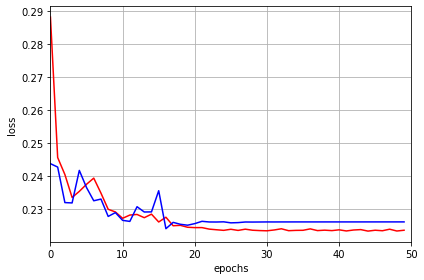

In [ ]:
# loss 그래프 확인해보기

import matplotlib.pyplot as plt

plt.plot(range(CFG["EPOCHS"]), new_train_loss, color='r')
plt.plot(range(CFG["EPOCHS"]), new_val_loss, color='b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, CFG["EPOCHS"]) # 일정한 scale
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()
    
    thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    pred_labels = []
    true_labels = []
    
    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(x_s)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [ ]:
# 0.56
# 0.54
# 0.51
# 0.51 
# 0.76
# 0.81
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)
print(f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]')

  0%|          | 0/45 [00:00<?, ?it/s]

Best Threshold : [0.35], Score : [0.80100]


In [ ]:
test_datasets = CustomDataset(test, None, False)
test_loaders = DataLoader(test_datasets, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [ ]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()
    
    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred
        
    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)
    print('Done.')
    return test_predict

In [ ]:
preds = inference(best_student_model, test_loaders, best_threshold, device)

  0%|          | 0/95 [00:00<?, ?it/s]

Done.


In [ ]:
test_datasets1 = CustomDataset(val_X, None, False)
test_loaders1 = DataLoader(test_datasets1, batch_size = CFG['BATCH_SIZE'], shuffle=False)



In [ ]:
submit = pd.read_csv('/content/drive/Shareddrives/2022건설기계오일상태분류AI경진대회/dataset/sample_submission.csv')
submit['Y_LABEL'] = preds
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [ ]:
submit.to_csv('./submit_ALweight2_robust_NObatch.csv', index=False)